In [1]:
import time
start = time.time()
#importar datos y librerias
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import signal
import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from scipy.stats import boxcox
from scipy import special
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge
from scipy.ndimage.interpolation import shift
from sklearn.linear_model import Ridge
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
def Mape(y,y_pred,sample_weight):
    return np.mean(np.abs((y-y_pred)/y))*100

def isFestivo(x):
    if x:
        return 1
    else:
        return 0
    
def isFestivo1(x):
    if ((np.datetime64(x) in festivos.values) or (np.datetime64(x) in festivos2.values)):
        return 1
    else:
        return 0

def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

def triangular(x, a, b, c):
    return max( min( (x-a)/(b-a), (c-x)/(c-b) ), 0 )
U = np.arange(1,365)

In [3]:
clima=pd.read_excel("Consumo.xlsx",index_col=0)
consumo=pd.read_excel("Data1.xlsx").drop("Unnamed: 2",axis=1)
consumo1=pd.read_excel("Data1.xlsx").drop("Unnamed: 2",axis=1)
consumo1["fecha1"]=consumo.fecha.copy()
consumo1=consumo1.set_index("fecha")

consumo1["min"]=clima["mín"].copy()
consumo1["max"]=clima["max"].copy()

    
consumo1["ones"]=1
consumo1["week"]=consumo1.fecha1.dt.week
consumo1["month"]=consumo1.fecha1.apply(lambda x:x.month)
consumo1["day"]=consumo1.fecha1.dt.weekday
consumo1["Nubosidad"]=clima.Nubosidad.copy()
consumo1["num"]=np.arange(0,len(consumo1.index))+1

consumo1.tail()

,MWh,fecha1,min,max,ones,week,month,day,Nubosidad,num
fecha,,,,,,,,,,
2020-02-14,198104.110000,2020-02-14,11.452886,25.020703,1,7,2,4,12.5,5889
2020-02-15,197219.405000,2020-02-15,10.369994,25.439110,1,7,2,5,12.5,5890
2020-02-16,165175.599136,2020-02-16,9.353056,25.451059,1,7,2,6,12.5,5891
2020-02-17,193444.758000,2020-02-17,10.336112,27.094038,1,8,2,0,12.5,5892
2020-02-18,205066.911000,2020-02-18,12.169421,28.566552,1,8,2,1,12.5,5893


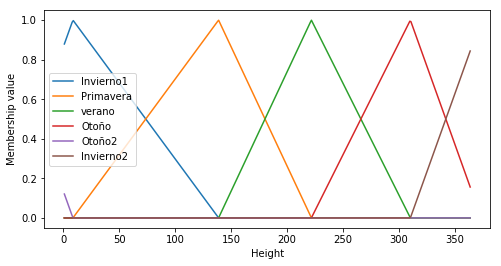

In [4]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],
}


plt.figure(figsize=(8,4))
lines = []
for fuzzy_set in height.keys():
    memberships = [ triangular(x, *height[fuzzy_set]) for x in U ]
    # plot the chart
    tmp, = plt.plot(U, memberships, label=fuzzy_set)
    lines.append(tmp)
plt.legend(handles=lines)
plt.xlabel("Height")
plt.ylabel("Membership value")
plt.show()
x=[dia%max(U) for dia in range(1,len(consumo.MWh)+1)]


datos=pd.DataFrame()
for element in x:
    l=[]    
    for fuzzy_set in height.keys():
        p=triangular(element, *height[fuzzy_set])
        l.append(float(p))
    l=pd.DataFrame(l)
    datos=datos.append(l.T)
    
datos["fecha"]=consumo.fecha
t=np.arange(1,len(consumo.MWh)+1)
datos = datos.set_index('fecha')
datos.columns=["inv1","prim","ver","oto1","oto2","inv2"]

In [5]:
n=-10

## Mínima

8.229317401520813


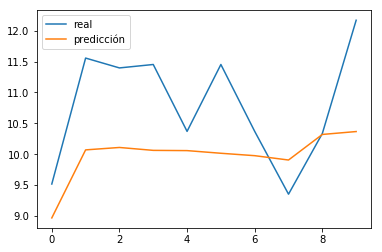

In [6]:
X=consumo1.drop(["fecha1","MWh","min","max","Nubosidad"],axis=1)
y=consumo1["min"]

Xmax=X.max()
my=y.mean()
sy=y.std()

X_norm=X/Xmax
y_norm=(y-my)/sy


X_norm["inv1"]=datos.inv1.values
X_norm["inv2"]=datos.inv2.values
X_norm["prim"]=datos.prim.values
X_norm["ver"]=datos.ver.values
X_norm["oto1"]=datos.oto1.values
X_norm["oto2"]=datos.oto2.values

X_norm["eureqa"]=X_norm.week*X_norm.prim
X_norm["eureqa2"]=X_norm.ver*X_norm.oto1
X_norm["eureqa3"]=X_norm.num**2



X_norm1=pd.get_dummies(X_norm,columns=["week","month","day"])




X_norm1=X_norm1.drop(["month_1.0","day_1.0","week_1.0"],axis=1)



X_train, X_test = X_norm1[:n].values, X_norm1[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

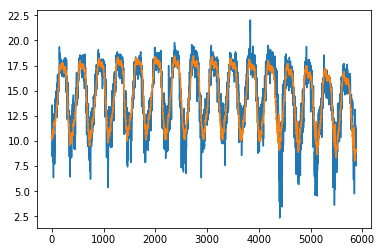

In [7]:
plt.plot(y_train)
plt.plot(reg.predict(X_train))

In [12]:
clima_modelo=pd.DataFrame(index=consumo1.index)
clima_modelo["min"]=reg.predict(X_norm1)

In [13]:
clima_modelo.head()

,min
fecha,
2004-01-01,10.132812
2004-01-02,10.167969
2004-01-03,10.218750
2004-01-04,10.234375
2004-01-05,10.218750


## Máxima

3.2547991457778003


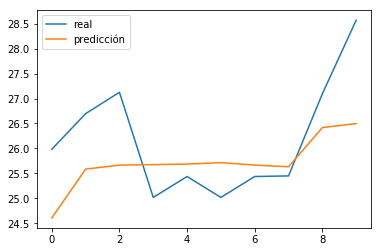

In [14]:
X=consumo1.drop(["fecha1","MWh","min","max","Nubosidad"],axis=1)
y=consumo1["max"]

Xmax=X.max()
my=y.mean()
sy=y.std()

X_norm=X/Xmax
y_norm=(y-my)/sy


X_norm["inv1"]=datos.inv1.values
X_norm["inv2"]=datos.inv2.values
X_norm["prim"]=datos.prim.values
X_norm["ver"]=datos.ver.values
X_norm["oto1"]=datos.oto1.values
X_norm["oto2"]=datos.oto2.values

X_norm["eureqa3"]=X_norm.num**2



X_norm1=pd.get_dummies(X_norm,columns=["week","month","day"])




X_norm1=X_norm1.drop(["month_1.0","day_1.0","week_1.0"],axis=1)



X_train, X_test = X_norm1[:n].values, X_norm1[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

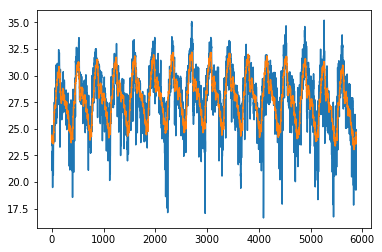

In [15]:
plt.plot(y_train)
plt.plot(reg.predict(X_train))

In [16]:
clima_modelo["max"]=reg.predict(X_norm1)

## Nubosidad

73.52380279606037


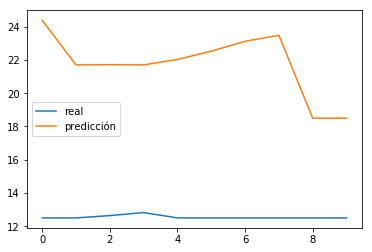

In [19]:
X=consumo1.drop(["fecha1","MWh","min","max","Nubosidad"],axis=1)
y=consumo1["Nubosidad"]

Xmax=X.max()
my=y.mean()
sy=y.std()

X_norm=X/Xmax
y_norm=(y-my)/sy


X_norm["inv1"]=datos.inv1.values
X_norm["inv2"]=datos.inv2.values
X_norm["prim"]=datos.prim.values
X_norm["ver"]=datos.ver.values
X_norm["oto1"]=datos.oto1.values
X_norm["oto2"]=datos.oto2.values

X_norm["eureqa1"]=X_norm.week*X_norm.ver
X_norm["eureqa2"]=X_norm.prim*X_norm.ver*X_norm.week**2
X_norm["eureqa3"]=X_norm.num**7*np.round(X_norm.num**4)*np.sqrt(.2015*X_norm.ver)
X_norm["eureqa4"]=X_norm.week*X_norm.prim*X_norm.ver
X_norm["eureqa5"]=X_norm.week**2*X_norm.ver



X_norm1=pd.get_dummies(X_norm,columns=["week","month","day"])




X_norm1=X_norm1.drop(["month_1.0","day_1.0","week_1.0"],axis=1)



X_train, X_test = X_norm1[:n].values, X_norm1[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

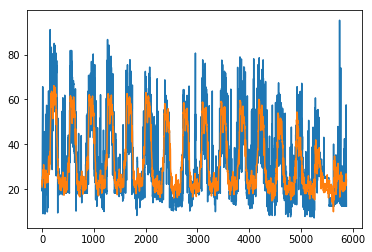

In [20]:
plt.plot(y_train)
plt.plot(reg.predict(X_train))

In [21]:
clima_modelo["Nubosidad"]=reg.predict(X_norm1)

In [22]:
clima_modelo.to_excel("Clima modelo.xlsx")